# Sea level budget

In [3]:
import numpy as np
import sys
sys.path.append('../code')
import SeaLevelContrib as slc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import IPython.display
import importlib
import netCDF4
import xarray as xr

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [26]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

In [4]:
path_outputs = '../outputs/'

### Namelist

In [33]:
# Pick a region name (see choices bellow): 
tg_sel = 'NS_Fred16' # Tide gauge selection
opt_glaciers = 'marzeion15' # marzeion15 for Marzeion et al. 2015
                            # zemp19 for Zemp et al. 2019
opt_antarctica = 'rignot19' # rignot19 or imbie18
opt_greenland = 'mouginot19' # No alternative yet but IMBIE is used in 
                             #Greenland.ipynb
opt_tws = 'humphrey19' # humphrey19 for Humphrey and Gudmundson 2019
#!!! Nodal cycle only included for regression method, not yet for dynamical model
opt_wind_ibe = ['regression','ERA5'] # Method 'regression' or 'dynamical_model' 
                          # 'NCEP1': Regression to NCEP1 (1948 to now)
                          # 'ERA5' : Regression to ERA5 (1979 to now)
                          # 'WAQUA' : Use the barotropic ocean model WAQUA
opt_steric = ['EN4','ENS',4000] 
                # [0]: Poduct, only 'EN4' available so far
                # [1]: Region on which to average the steric effect: ENS, EBB, NWS
                # [2]: Depth of integration in meters

In [35]:
reg_dict = {'ZSM' : [20, 22, 23, 24, 25, 32], # Zeespiegelmonitor (Dutch coast)
            # North Sea Frederikse et al. 2016
            'NS_Fred16': [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754],
            'Newlyn': [202], 
            'Brest': [1], 
            'Vlissingen': [20]}

tg_id = reg_dict[tg_sel]
tg_id

[20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754]

In [36]:
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-10:]

,20,32,236,7,80,89,302,47,830,361,95,754,Average
time,,,,,,,,,,,,,
2009,12.172611,9.902721,5.134694,13.770455,6.164286,-1.808621,1.629885,2.333333,3.579167,4.283333,7.959091,5.575,5.891330
2010,12.372611,8.702721,3.134694,11.870455,0.064286,-7.308621,-1.570115,-2.266667,2.745833,0.933333,8.809091,7.475,3.746885
2011,12.772611,11.802721,8.134694,17.770455,14.964286,3.191379,1.829885,4.333333,1.912500,1.933333,9.659091,8.075,8.031607
2012,12.072611,11.202721,6.534694,15.070455,10.364286,-0.508621,0.529885,1.133333,1.079167,2.933333,8.859091,6.475,6.312163
2013,10.672611,8.802721,3.334694,11.570455,-1.235714,-2.608621,-1.770115,-0.266667,1.979167,0.833333,8.759091,6.875,3.912163
2014,14.472611,13.502721,8.334694,15.070455,-6.035714,-4.208621,1.629885,4.033333,5.279167,5.333333,11.459091,7.875,6.395496
2015,14.772611,14.902721,11.434694,23.570455,18.064286,1.191379,2.329885,4.633333,5.279167,NaN,10.859091,8.675,10.519329
2016,15.072611,14.202721,8.934694,17.970455,13.264286,-3.708621,0.729885,1.733333,NaN,NaN,12.059091,NaN,8.917606
2017,16.672611,17.202721,12.634694,23.870455,18.364286,3.591379,3.529885,5.133333,NaN,NaN,13.959091,NaN,12.773162


In [37]:
if opt_steric[0] == 'EN4':
    steric_df = slc.StericSL_EN4(max_depth=opt_steric[2], mask_name=opt_steric[1])
else:
    print('ERROR: option for opt_steric[0] undefined')
    
for i in range(len(tg_id)):
    print('Working on tide gauge id: '+ str(tg_id[i]))
    gia_ts_df = slc.GIA_ICE6G([tg_id[i]])
    
    if opt_glaciers == 'marzeion15':
        glac_ts_df = slc.glaciers_m15([tg_id[i]], extrap=True, del_green=True)
    elif opt_glaciers == 'zemp19':
        glac_ts_df = slc.glaciers_zemp19([tg_id[i]], extrap=True, del_green=True)
    else:
        print('ERROR: option for opt_glaciers undefined')
    
    if opt_antarctica == 'imbie18':
        ant_df = slc.ant_imbie_glo(extrap=True) * slc.ices_fp(tg_id, 'mit_unif', 
                                                              'ant')
    elif opt_antarctica == 'rignot19':
        ant_df = slc.ant_rignot19() * slc.ices_fp([tg_id[i]] , 'mit_unif', 'ant')
    else:
        print('ERROR: option for opt_antarctica undefined')
    
    green_df = slc.green_mouginot19_glo() * slc.ices_fp([tg_id[i]] , 'mit_unif', 
                                                        'green')
    tws_df = slc.tws_glo_humphrey19(extrap=True)
    sealevel_df = steric_df
    sealevel_df = sealevel_df.join([gia_ts_df, glac_ts_df, ant_df, green_df, 
                                    tws_df], how='inner')
    sealevel_df['Total'] = sealevel_df.sum(axis=1)

    if opt_wind_ibe[0] == 'regression':
        diff_tg_df = tg_df.Average - sealevel_df.Total
        diff_tg_df = diff_tg_df.to_frame(name='height').dropna()
        wpn_ef_df = slc.make_wpn_ef([tg_id[i]], diff_tg_df, with_trend=False, 
                                product=opt_wind_ibe[1])
    elif opt_wind_ibe[0] == 'dynamical_model':
        print('!!! This option does not include nodal cycle')
        if opt_wind_ibe[1] == 'WAQUA':
            wpn_ef_df = slc.make_waqua_df(tg_id[i])
        else:
            print('ERROR: option for opt_wind_ibe[1] undefined')
    else:
        print('ERROR: option for opt_wind_ibe[0] undefined')
    
    sealevel_df = sealevel_df.join(wpn_ef_df, how='inner')
    del sealevel_df['Total']
    sealevel_df.insert(0, 'Total', sealevel_df.sum(axis=1))
    sealevel_df['Total'] = sealevel_df['Total'] - sealevel_df['Total'].mean()
    sealevel_df.index.name = 'time'
    sealevel_df = sealevel_df - sealevel_df.iloc[0,:]
    sealevel_df = pd.concat([sealevel_df], axis=1, keys=[str(tg_id[i])])

    if i==0:
        slall_df = sealevel_df.copy()
    else:
        slall_df = pd.concat([slall_df, sealevel_df], axis=1)
        
slall_df.iloc[-10:]

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Working on tide gauge id: 20
found point 51.5 3.5
Working on tide gauge id: 32
found point 52.5 4.5
Working on tide gauge id: 236
found point 53.25 5.25
Working on tide gauge id: 7
found point 53.75 8.75
Working on tide gauge id: 80
found point 55.5 8.5
Working on tide gauge id: 89
found point 57.5 10.0
Working on tide gauge id: 302
found point 58.0 7.5
Working on tide gauge id: 47
found point 59.0 5.75
Working on tide gauge id: 830
found point 60.25 358.75
Working on tide gauge id: 361
found point 57.25 358.0
Working on tide gauge id: 95
found point 55.0 358.5
Working on tide gauge id: 754
found point 52.5 1.75


20                                                            \
          Total    Steric    GIA  Glaciers Antarctica Greenland       TWS   
time                                                                        
2009   7.078905  6.060237  0.120  0.927456   0.725974  0.126684  0.404047   
2010   5.277952  6.852622  0.124  0.962603   0.785952  0.142420  0.364924   
2011  10.626675  7.358719  0.128  1.005537   0.849611  0.159688  0.196228   
2012   7.289902  5.395810  0.132  1.042035   0.917078  0.177812  0.507848   
2013   5.377684  6.454923  0.136  1.071208   0.988484  0.193781  0.504573   
2014   8.440672  7.630830  0.140  1.107194   1.063955  0.201350  0.352733   
2015  12.044568  6.553563  0.144  1.143180   1.143622  0.212807  0.385261   
2016   9.006638  7.061321  0.148  1.179166   1.227612  0.224757  0.385261   
2017  13.967861  8.565661  0.152  1.215152   1.316054  0.239016  0.385261   
2018   7.974314  6.798176  0.156  1.251139   1.409077  0.243852  0.385261   

                                    ...        754                             \
         Nodal      Wind  Pressure  ...      Total    Steric    GIA  Glaciers   
time                                ...                                         
2009 -0.606409 -0.812581  0.133497  ...   7.607158  6.060237  0.810  0.941570   
2010 -0.787780 -3.234734  0.067945  ...   6.231724  6.852622  0.837  0.975693   
2011 -0.883124  1.299629  0.512389  ...  11.294883  7.358719  0.864  1.018188   
2012 -0.881679 -0.293683  0.292682  ...   8.185078  5.395810  0.891  1.054563   
2013 -0.783609 -3.448407  0.260733  ...   6.465736  6.454923  0.918  1.084169   
2014 -0.599983 -1.365186 -0.090221  ...   9.567834  7.630830  0.945  1.119830   
2015 -0.351527  2.211885  0.601777  ...  12.569504  6.553563  0.972  1.155490   
2016 -0.066287 -1.525143  0.371952  ...   9.220812  7.061321  0.999  1.191150   
2017  0.223541  1.439318  0.431858  ...  15.536605  8.565661  1.026  1.226810   
2018  0.485242 -3.035846  0.281414  ...   9.093602  6.798176  1.053  1.262471   

                                                                   
     Antarctica Greenland       TWS     Nodal      Wind  Pressure  
time                                                               
2009   0.733396  0.080683  0.404047 -0.249691 -1.203031  0.029946  
2010   0.793988  0.090705  0.364924 -0.472318 -3.246442  0.035554  
2011   0.858298  0.101703  0.196228 -0.623123  1.420657  0.100215  
2012   0.926455  0.113246  0.507848 -0.685083 -0.077521  0.058760  
2013   0.998591  0.123416  0.504573 -0.651203 -3.031557  0.064824  
2014   1.074834  0.128237  0.352733 -0.525309 -1.135570 -0.022750  
2015   1.155315  0.135534  0.385261 -0.321611  2.418596  0.115356  
2016   1.240164  0.143144  0.385261 -0.063100 -1.814691  0.078563  
2017   1.329510  0.152226  0.385261  0.221043  2.545047  0.085047  
2018   1.423484  0.155305  0.385261  0.498746 -2.549027  0.066186  

[10 rows x 120 columns]

In [38]:
# Compute the average contributors at all tide gauges
slmean_df = slall_df.groupby(level=1, axis=1, sort=False).mean()
slmean_df = slmean_df.join(tg_df.Average, how='inner')
slmean_df = slmean_df.rename(columns={'Average': 'Obs'})
slmean_df['Obs'] = slmean_df['Obs'] - slmean_df['Obs'].iloc[0]

#slmean_df = slmean_df.loc[1958:2014] # Select date to fit Fred16 study.
#slmean_df
slmean_df.iloc[-10:]

#!!! Modify the name if necessary:
#slmean_df.to_csv(path_outputs+'SLBudget_Steric4000m_ERA5_1979_2018.csv')

,Total,Steric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,
2009,6.011908,6.060237,0.15750,0.831601,0.735087,0.002763,0.404047,-0.736568,-0.932723,-0.510036,7.189087
2010,5.289173,6.852622,0.16275,0.861207,0.795818,0.003106,0.364924,-0.869388,-1.803363,-1.078503,5.044643
2011,8.673215,7.358719,0.16800,0.894748,0.860276,0.003483,0.196228,-0.919239,1.052524,-0.941522,9.329365
2012,6.861776,5.395810,0.17325,0.925342,0.928590,0.003878,0.507848,-0.880497,0.442757,-0.635202,7.609921
2013,5.578985,6.454923,0.17850,0.947030,1.000892,0.004226,0.504573,-0.757532,-1.592563,-1.161063,5.209921
2014,7.927383,7.630830,0.18375,0.976506,1.077311,0.004391,0.352733,-0.564226,-1.826227,0.092316,7.693254
2015,10.663203,6.553563,0.18900,1.005981,1.157978,0.004641,0.385261,-0.322398,2.542787,-0.853610,11.817087
2016,7.895534,7.061321,0.19425,1.035457,1.243022,0.004902,0.385261,-0.059343,-0.610929,-1.358405,10.215364
2017,13.408935,8.565661,0.19950,1.064932,1.332574,0.005213,0.385261,0.195244,2.192252,-0.531702,14.070919


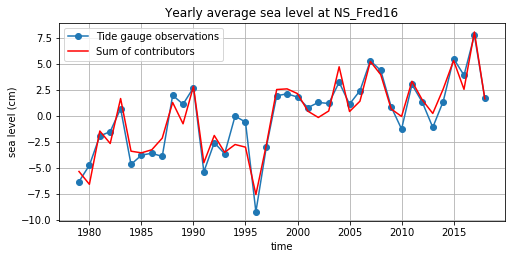

In [39]:
#ys = 1979 #1950 for NCEP1
#ye = 2017

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(slmean_df.Obs - slmean_df.Obs.mean(), 'o-', label='Tide gauge observations')
ax.plot(slmean_df.Total - slmean_df.Total.mean() , 'r-', label='Sum of contributors')
#ax.plot(sealevel_df.index, sealevel_df['Nodal'], 'y-')
#ax.plot(sealevel_df.index, sealevel_df['Glaciers'], '-')
#ax.plot(TWS_df, '-')
ax.set_aspect(1)
#ax.set_xlim([ys,2020])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Yearly average sea level at '+tg_sel)
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('Figures/CompObsContrib.pdf')

Sum of difference (cm) : 
2.886579864025407e-15
Normalised root mean square error (cm): 
0.1717031809618637
Normalised absolute error (cm): 
0.8585738388084186


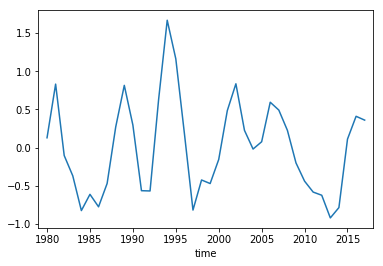

In [40]:
diff_df = slmean_df.Obs - slmean_df.Total
#diff_df = diff_df.loc[1979:]
#diff_df = diff_df.dropna()
diff_df = diff_df - diff_df.mean()
print('Sum of difference (cm) : ')
print(diff_df.sum())
print('Normalised root mean square error (cm): ')
print( np.sqrt( (diff_df**2).sum() ) / len(diff_df))
print('Normalised absolute error (cm): ')
print(np.abs(diff_df).sum() / len(diff_df))
diff_df = diff_df.rolling( 3, center=True).mean()
diff_df.plot()

,Lin_trend,Acceleration
Total,1.998782,2.092725e-02
Steric,1.669653,-1.591763e-02
GIA,0.052500,1.439672e-16
Glaciers,0.281422,1.201594e-03
Antarctica,0.335317,2.228775e-02
Greenland,0.001270,1.048876e-04
TWS,0.072815,-3.609775e-03
Nodal,-0.129079,1.625969e-02
Wind,-0.233765,-4.801507e-03
Pressure,-0.051350,5.402235e-03


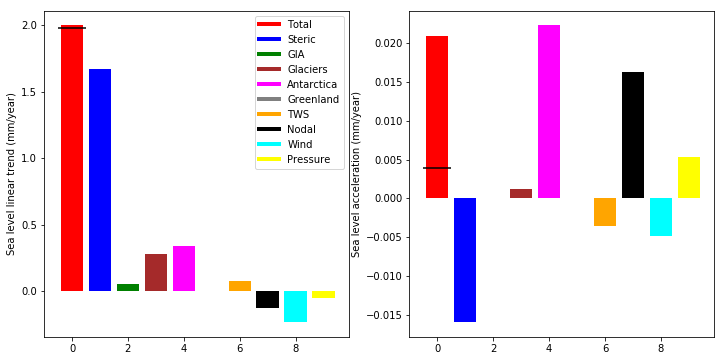

In [41]:
# Study the trend and acceleration budget
lin_trend = np.polyfit(slmean_df.index, slmean_df * 10, 1)[0,:]  # Convert from cm to mm
stat_df = pd.DataFrame(data = dict(Lin_trend = lin_trend), index=slmean_df.columns)

acceleration = 2 * np.polyfit(slmean_df.index, slmean_df * 10, 2)[0,:] # Convert from cm^2 / year to mm^2 / year
stat_df['Acceleration'] = acceleration

colors = ['red', 'blue', 'green', 'brown', 'magenta', 'grey', 'orange', 'black', 'cyan', 'yellow']
ind = np.arange(len(slmean_df.columns) - 1 )

legend_elements = []
for i in ind:
    legend_elements.append(Line2D([0], [0], color = colors[i], lw = 4, label = slmean_df.columns[i]))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(ind, lin_trend[:-1], color=colors)
ax[0].hlines(y=lin_trend[-1], xmin=-0.5, xmax=0.5, color='black')
ax[0].set_ylabel('Sea level linear trend (mm/year)')
#ax[0].set_title('tide gauge ?')

ax[1].bar(ind, acceleration[:-1], color=colors)
ax[1].hlines(y=acceleration[-1], xmin=-0.5, xmax=0.5, color='black')
ax[1].set_ylabel('Sea level acceleration (mm/year)')
#ax[1].set_title('tide gauge ?')

ax[0].legend(handles=legend_elements, loc='upper right')
#ax.set_xticks(ind)
stat_df

In the figure above the black bars represent the linear trend and accelartion computed from the tide gauges.

Text(0.5, 0.98, 'Sea level budget for the Dutch coast 1979-2018')

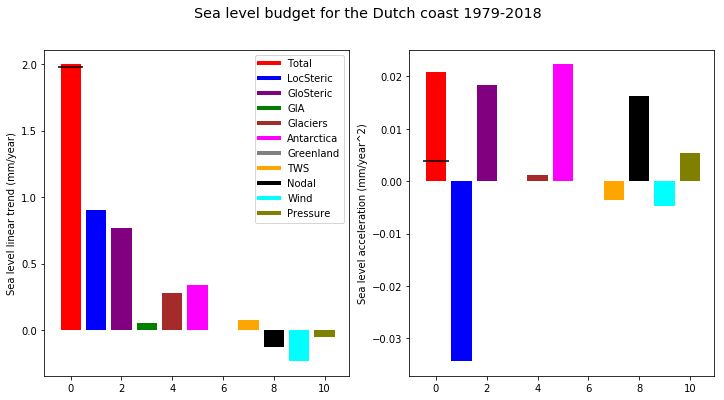

In [42]:
# Study the trend and acceleration budget
# Same as previous graph but split local and global steric effects
sl_g_df = slmean_df.copy()
sl_g_df['GloSteric'] =  slc.LevitusSL(extrap=True, extrap_back=True)
sl_g_df['Steric'] = sl_g_df['Steric'] - sl_g_df['GloSteric']
sl_g_df = sl_g_df.rename(columns={'Steric': 'LocSteric'})
# Rearange the columns for plotting
cols = sl_g_df.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
sl_g_df = sl_g_df[cols]

lin_trend = np.polyfit(sl_g_df.index, sl_g_df * 10, 1)[0,:]  
# Converted from cm to mm
stat_df = pd.DataFrame(data = dict(Lin_trend = lin_trend), index=sl_g_df.columns)

acceleration = 2 * np.polyfit(sl_g_df.index, sl_g_df * 10, 2)[0,:] 
# Convert from cm / year^2 to mm / year^2
stat_df['Acceleration'] = acceleration

colors = ['red', 'blue', 'purple', 'green', 'brown', 'magenta', 'grey', 
          'orange', 'black', 'cyan', 'olive']
ind = np.arange(len(sl_g_df.columns) - 1 )

legend_elements = []
for i in ind:
    legend_elements.append(Line2D([0], [0], color = colors[i], lw = 4, 
                                  label = sl_g_df.columns[i]))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(ind, lin_trend[:-1], color=colors)
ax[0].hlines(y=lin_trend[-1], xmin=-0.5, xmax=0.5, color='black')
ax[0].set_ylabel('Sea level linear trend (mm/year)')
#ax[0].set_title('tide gauge ?')

ax[1].bar(ind, acceleration[:-1], color=colors)
ax[1].hlines(y=acceleration[-1], xmin=-0.5, xmax=0.5, color='black')
ax[1].set_ylabel('Sea level acceleration (mm/year^2)')
#ax[1].set_title('tide gauge ?')

ax[0].legend(handles=legend_elements, loc='upper right')
#ax.set_xticks(ind)
fig.suptitle('Sea level budget for the Dutch coast 1979-2018', fontsize="x-large")

#!!! Modify the name if necessary:
#sl_g_df.to_csv(path_outputs+'SLBudget_Steric4000m_ERA5_1979_2018_withLocSteric.csv')

#fig.savefig('./Figures/SeaLevelBudgetDutchCoast_1979_2018_ERA5.pdf', dpi=150)

Comment on the choice of steric expansion location:
It seems that using the Bay of Biscay reduces the eror compared to extended North Sea.
On the other hand Norwegian Sea increases it.

Antarctica: 
Rignot et al. 2019 -> 0.315, 1.96
IMBIE 2018 -> 0.319, 1.99
More acceleration seems better

Using pressure as a regressor improves the budget closure. N. RMS: 0.308, N. AE: 1.93 

I had forgotten to add the nodal cycle. Including it improves the fit!

Computing the wind, nodal and pressure effects (linear fit) after removing the trend from the reconstruction improves the fit compared to computing the fit using a linear trend.

Using ERA5 leads to improve the model significantly, for the period 1979 and after:
- ERA5: rmse = 0.21, ae = 1.08
- NCEP1: rmse = 0.24, ae = 1.21

Using the extended Bay of Biscay area, mostly solves the trend problem but it introduces higher rms (0.27) and ae (1.30).

The same conclusion applies to stopping the integration of steric effect at 60N instead of the standard 69N. This is because steric trend in the region 60-69 is smaller than further South (see the Steric notebook). What is the most relevent for the North Sea?

Using sea level from WAQUA forced by ERA-interim increases the rmse (0.26) and ae (1.35) compared to linear regressions to ERA5 or NCEP1 reanalysis. This might be because of sea level variations external to the domain entering the domain.

One possible difference between KNMI projections and Deltares zsm is the vertical land motion: GIA from ICE6G provides 0.36mm/y for the Dutch tide gauges while 0.45 was used in the ZSM. That is still not much: 2 mm in 20 years.

The computation of acceleration is very sensitive to the period used to compute it even for the steric effect. Also it seems very difficult to get right. For example at the Brest tide gauge, observations show a deceleration while the budget shows an acceleration.
This points toward the need to consider longer time periods to study the acceleration.

Even in the period 1950-2017 the acceleration is difficult to get right. For the Dutch coast the budget gives twice larger values than the tide gauge observations. For that period it seems that for Newlyn, Brest and Dutch coast the trend is underestimated and the acceleration is overestimated.

Acceleration for the Dutch coast is very sensitive to the wind and steric effects: check starting point in 1950 compared to 1958 -> Also check over the ERA5 period

Split global and regional steric

Outline of paper:

Closing the sea level budget in the Netherlands

20th century reanalysis

Correlation between steric and tide gauges

Why did the wind change?

Steric, regional heat uptake vs transport

Influence of leaving Wadden Sea out of the budget?